In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from ogs6py.ogs import OGS
import vtuIO

In [69]:
files = ["DeVries/TH2M/results/TH2M_run_10_Q106_genpower_Residual_res10.pvd", "DeVries/TH2M/results/TH2M_run_10_Q149_genpower_Residual_res10.pvd","febex/TH2M/results/TH2M_run_10_Q106_genpower_Residual_res10_test.pvd","febex/TH2M/results/TH2M_run_10_Q149_genpower_Residual_res10.pvd","febex/TH2M/results/TH2M_run_10_Q149_genpower_Residual_res10_test_highclayrelperm.pvd"]

In [70]:
pts = {
"H1": (0.1575,0,0),
"H2": (0.42,0,0),
"GBM1": (0.590625,0,0),
"GBM2": (0.9625,0,0),
"GBM3": (1.35625,0,0),
"SC1": (1.43,0,0),
"SC2": (1.5,0,0),
"SC3": (1.58,0,0),
"EDZ1": (1.63,0,0),
"EDZ2": (1.7,0,0),
"EDZ3": (1.78,0,0),
"OPA1": (1.83,0,0),
"OPA2": (2,0,0),
"OPA3": (5,0,0),
"OPA4": (20,0,0),
"OPA5": (30,0,0),
"OPA6": (40,0,0),
"OPA7": (50,0,0)
}

pt_keys = ["H1", "H2", "GBM1", "GBM2", "GBM3", "SC1", "SC2", "SC3", "EDZ1", "EDZ2", "EDZ3", "OPA1", "OPA2", "OPA3", "OPA4", "OPA5", "OPA6", "OPA7"]
#pt_keys = ["GBM1", "GBM2", "SC2", "SC3", "EDZ1", "OPA1"]

def p_map(pt):
    if "GBM" in pt:
        return 0
    elif "SC" in pt or "EDZ" in pt:
        return 1
    elif "OPA" in pt:
        return 2

In [71]:
result_variables_th2m = ["temperature","gas_pressure","capillary_pressure",
                    "saturation", "liquid_density"]
result_variables_trm = ["temperature","pressure","saturation", "liquid_density"]

In [72]:
time = {}
pvdfile = {}
results = {}
names = []
for file in files:
    names.append(file.split("/")[0] + file.split("/")[-1].split(".")[0].replace("TH2M_run_10","").replace("genpower_Residual_res10",""))
    pvdfile[names[-1]] = vtuIO.PVDIO(f"../study/{file}", dim=2)
    time[names[-1]] = pvdfile[names[-1]].timesteps
    results[names[-1]] = pvdfile[names[-1]].read_time_series(result_variables_th2m, pts=pts)

In [73]:
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['font.size'] = 16

def seconds_to_years(seconds):
    return seconds / 365.2425 / 86400
def seconds_to_days(seconds):
    return seconds / 86400
def days_to_seconds(days):
    return days * 86400

def plot_page(t_min, t_max, var, log=False, prefix =""):
    y_label="S / 1"
    tobeplotted = {}
    if var=="temperature":
        for name in names:
            tobeplotted[name] = {loc: results[name][loc][var]-273.15 for loc in results[name]}
        y_label = "$T$ / $^\circ$C"    
    if var=="saturation":
        for name in names:
            tobeplotted[name] = {loc: results[name][loc][var] for loc in results[name]}

    if var=="gas_pressure":
        for name in names:
            tobeplotted[name] = {loc: results[name][loc][var]*1e-6 for loc in results[name]}
        
        y_label = "$p_\\mathrm{GR}$ / MPa"
    if var=="liquid_pressure":
        for name in names:
            tobeplotted[name] = {loc: (results[name][loc]["gas_pressure"]-results[name][loc]["capillary_pressure"])*1.e-6 for loc in results[name]}
        y_label = "$p_\\mathrm{LR}$ / MPa"
    if var=="liquid_density":
        for name in names:
            tobeplotted[name] = {loc: results[name][loc][var] for loc in results[name]}
        y_label = "$_\\mathrm{LR}$ / MPa"
    #if var=="relative_humidity":
    #    th2m = RH_th2m
    #    th2m_cp = RH_th2m_const
    #    trm = RH_trm
    #    trm_nolh = RH_trm_nolh
    #    y_label = "$RH$"
    if var=="capillary_pressure":
        for name in names:
            tobeplotted[name] = {loc: (results[name][loc]["capillary_pressure"])*1.e-6 for loc in results[name]}
        y_label = "$p_\\mathrm{cap}$ / MPa"        
        
    #pdf_pages = PdfPages(f"{prefix}_{Q}_{vd}_{var}"+".pdf")
    #fig = plt.figure(figsize=(8, 2))
    #plt.text(0.5, 0.5, "My Simulation Results", fontsize=16, ha='center', va='center')
    #plt.axis('off')
    #pdf_pages.savefig(fig)
    
    
    columns = 3
    rows = 6
    subfig_width = 5
    subfig_height = 3
    
    
    fig, axs = plt.subplots(nrows=rows, ncols=columns, 
                            figsize=(columns*subfig_width, rows*subfig_height), sharex=False)
 

    # Set the x-axis limits for all subplots
    for ax in axs.flat:
        ax.set_xlim(t_min/365,t_max/365)
    for r in range(rows):
        for c in range(columns):
            index = r*columns+c
            key = pt_keys[index]
            #print(r,c,index, key, pts[key])
            #print(f"TH2M max T {key}:", np.max(th2m[key]))
            #print(f"TH2M const max T {key}:", np.max(th2m_cp[key]))
            #print(f"TRM max T {key}:", np.max(trm[key]))
            #print(f"TRM nolh max T {key}:", np.max(trm_nolh[key]))
            for name in names:
                axs[r,c].plot(seconds_to_years(time[name]), tobeplotted[name][key], label=name)
            # plot the current data set in the current subplot
            axs[r,c].set_title(key,  fontweight='bold', fontstyle='italic') # set the title of the current subplot
  
 
    # Linestyles: '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    
    for i in range(rows):
        axs[i,0].set_ylabel(y_label) # set the title of the current subplot
    for i in range(columns):
        axs[rows-1,i].set_xlabel("time / years") # set the title of the current subplot
        #x_ticks = axs[rows-1, i].get_xticks()
        #axs[rows-1,i].set_xticklabels([f"{seconds_to_days(t):.1f}" for t in x_ticks])
        #axs[rows-1,i].set_xlim(t_min,t_max)
    
    axs[0, 0].legend()    
            
    fig.subplots_adjust(wspace=0.2, hspace=0.3)  # increase the spacing between subplots


    # Save the subplots to the PDF file
    #pdf_pages.savefig(fig)

    # Close the PdfPages object to finalize the PDF file
    #pdf_pages.close()
    

# 1. observation point based analysis

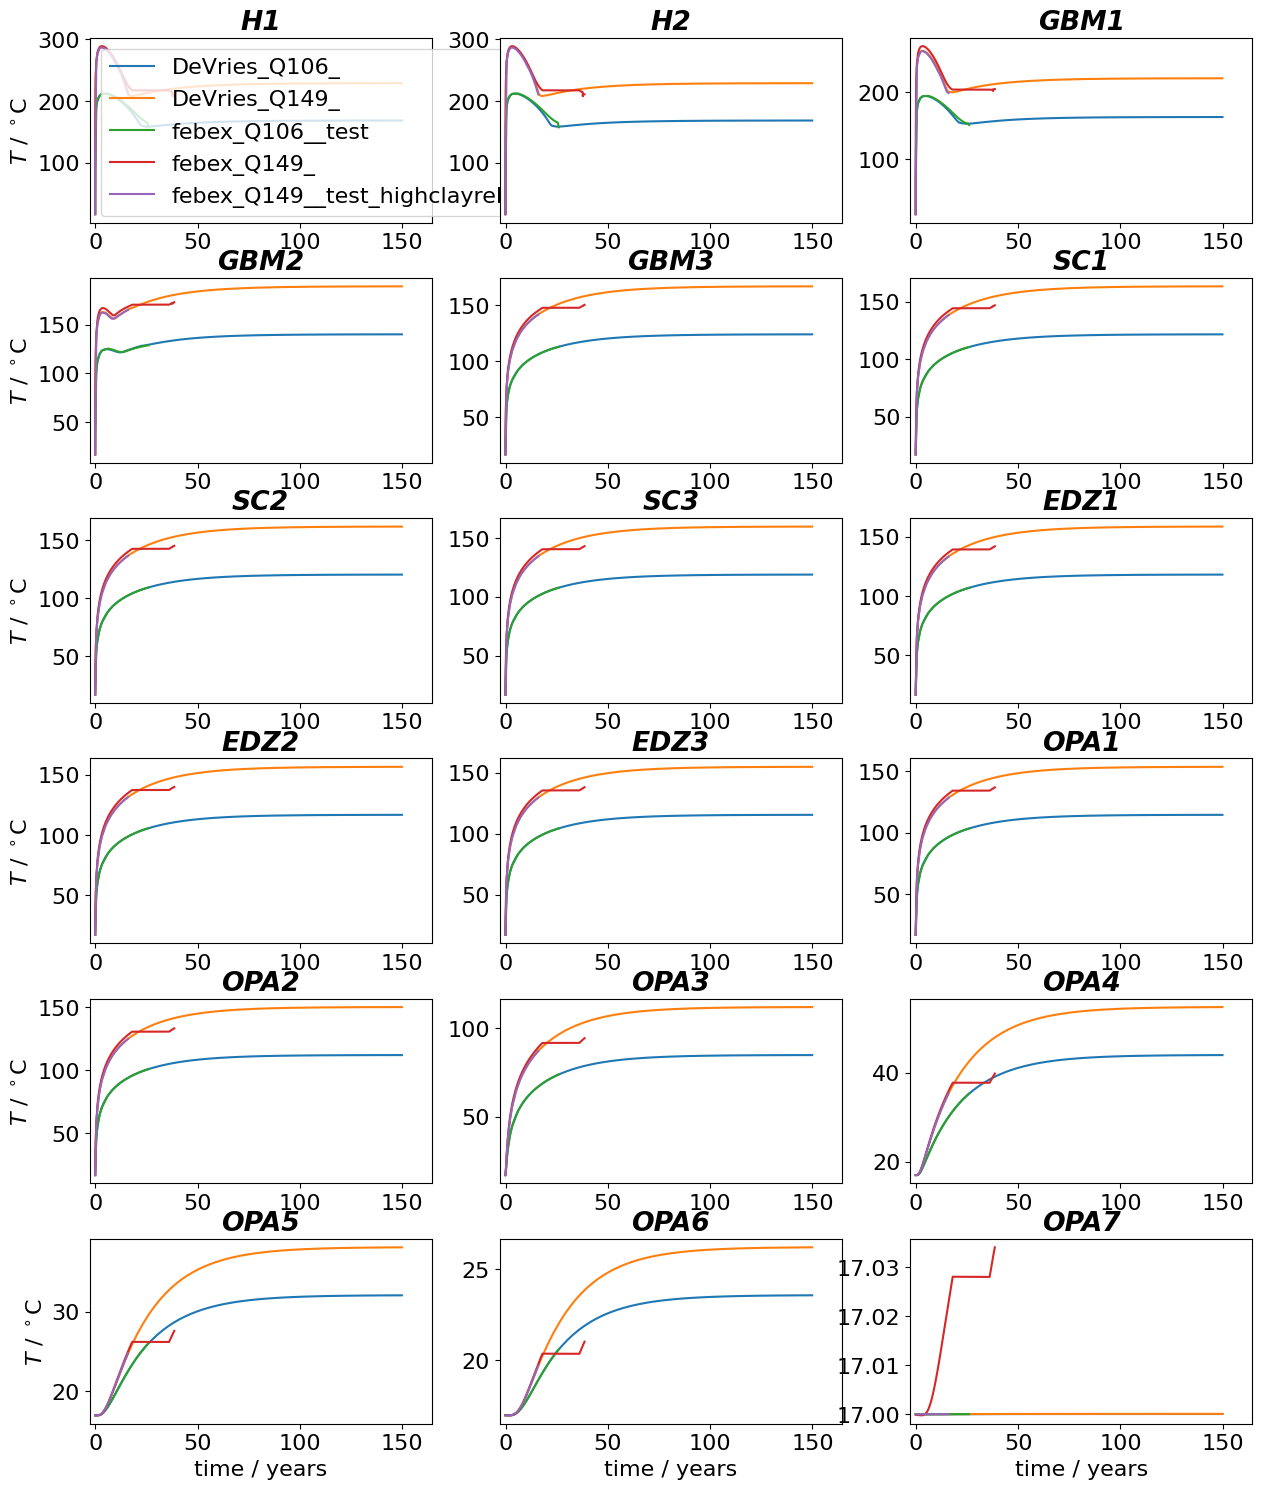

In [74]:
plot_page(-1000,60000, "temperature")

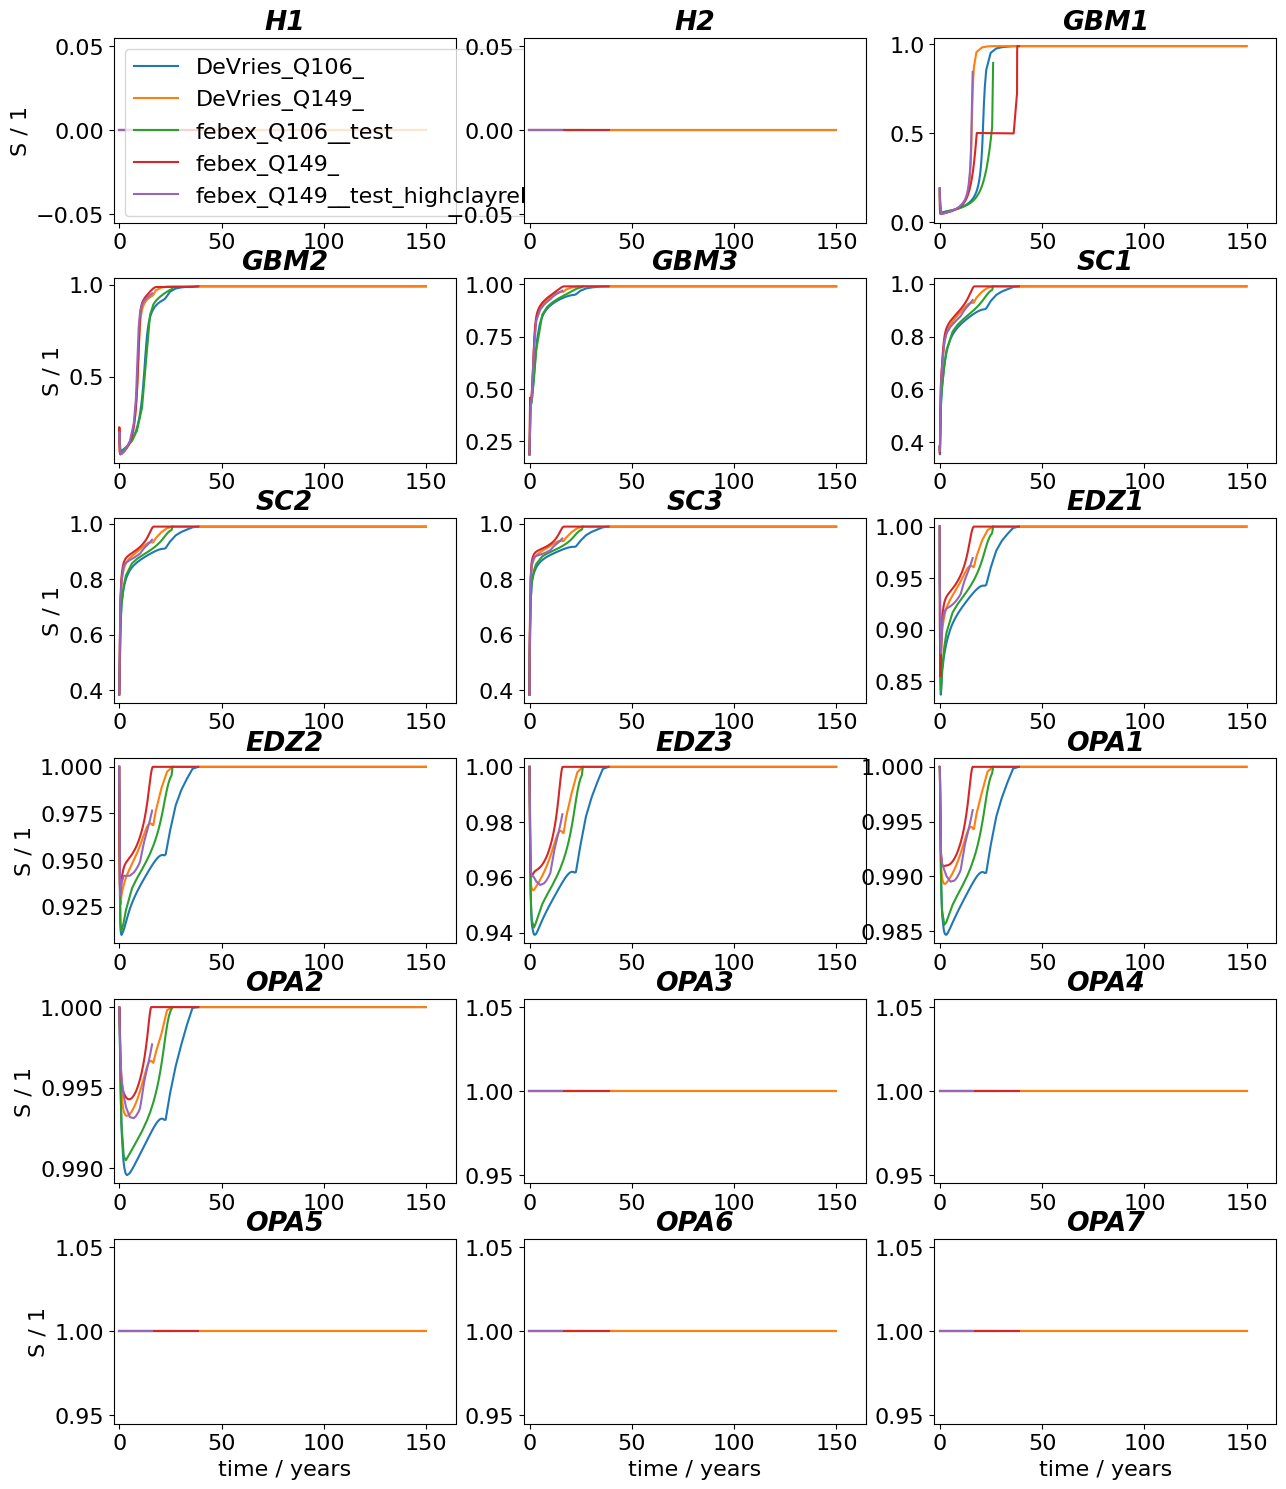

In [75]:
plot_page(-1000,60000, "saturation")

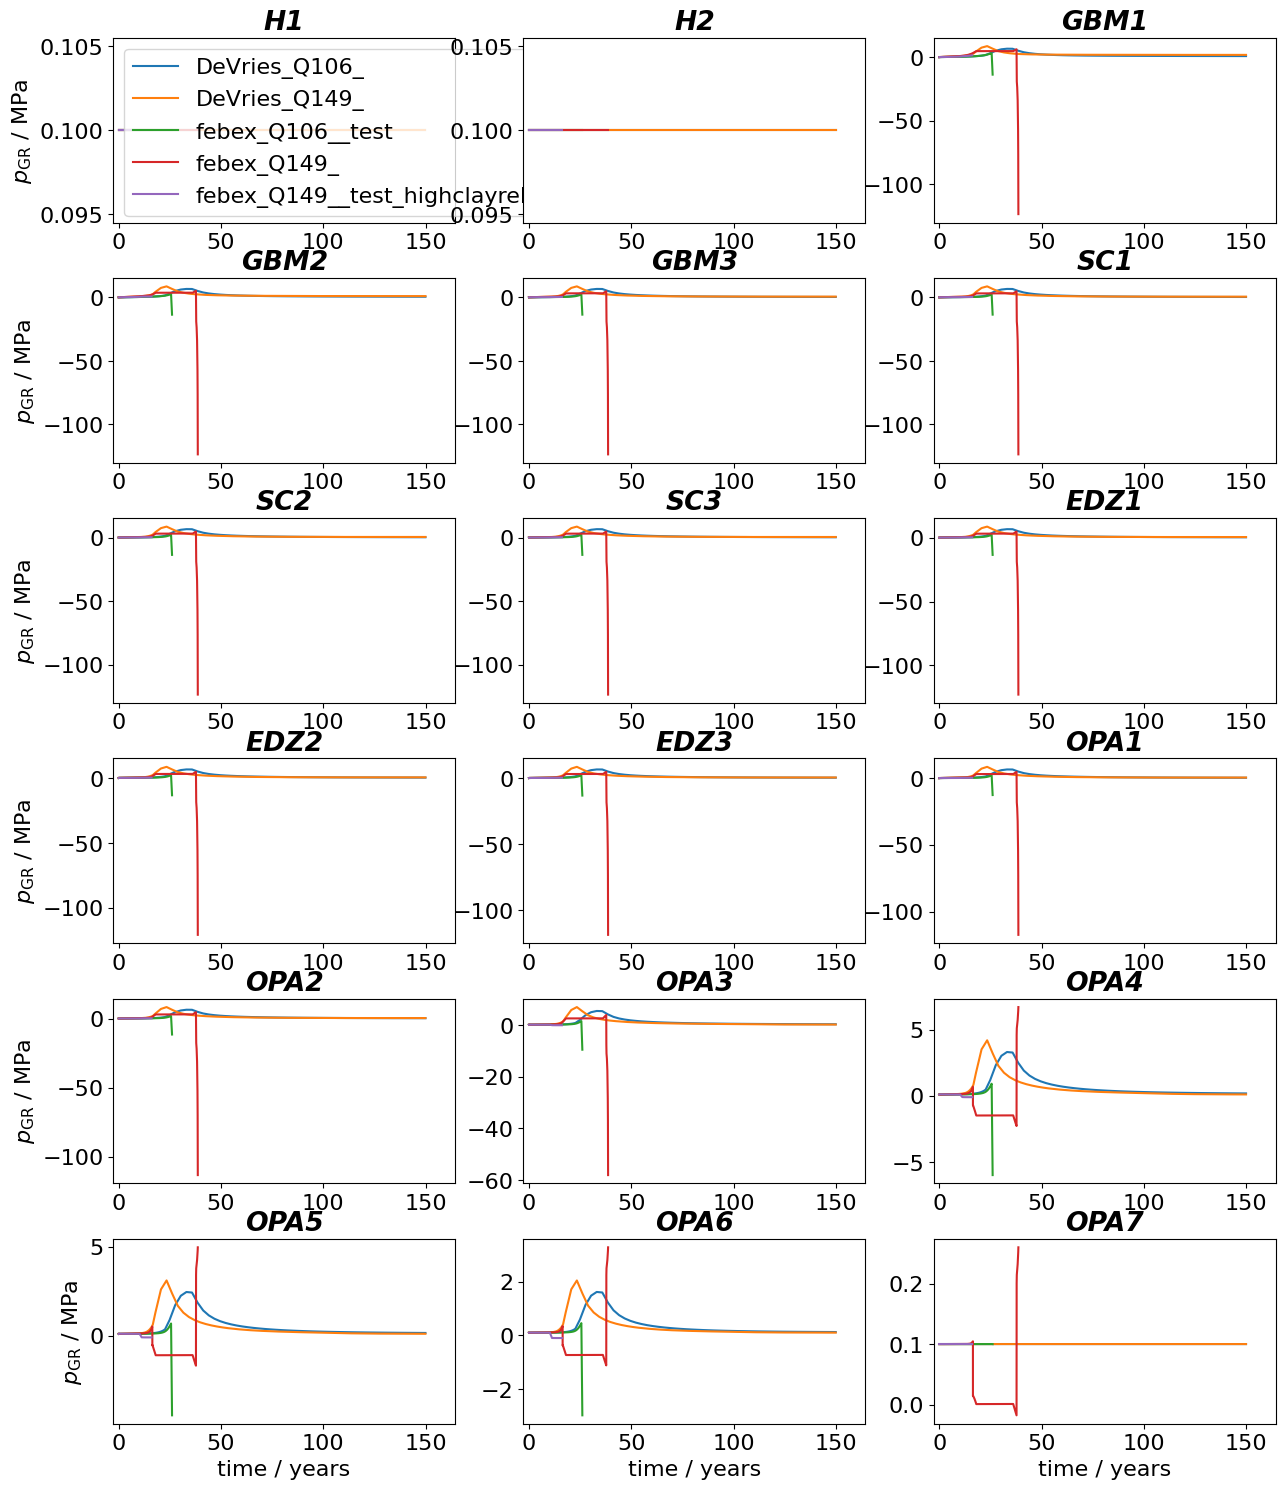

In [76]:
plot_page(-1000,60000, "gas_pressure")


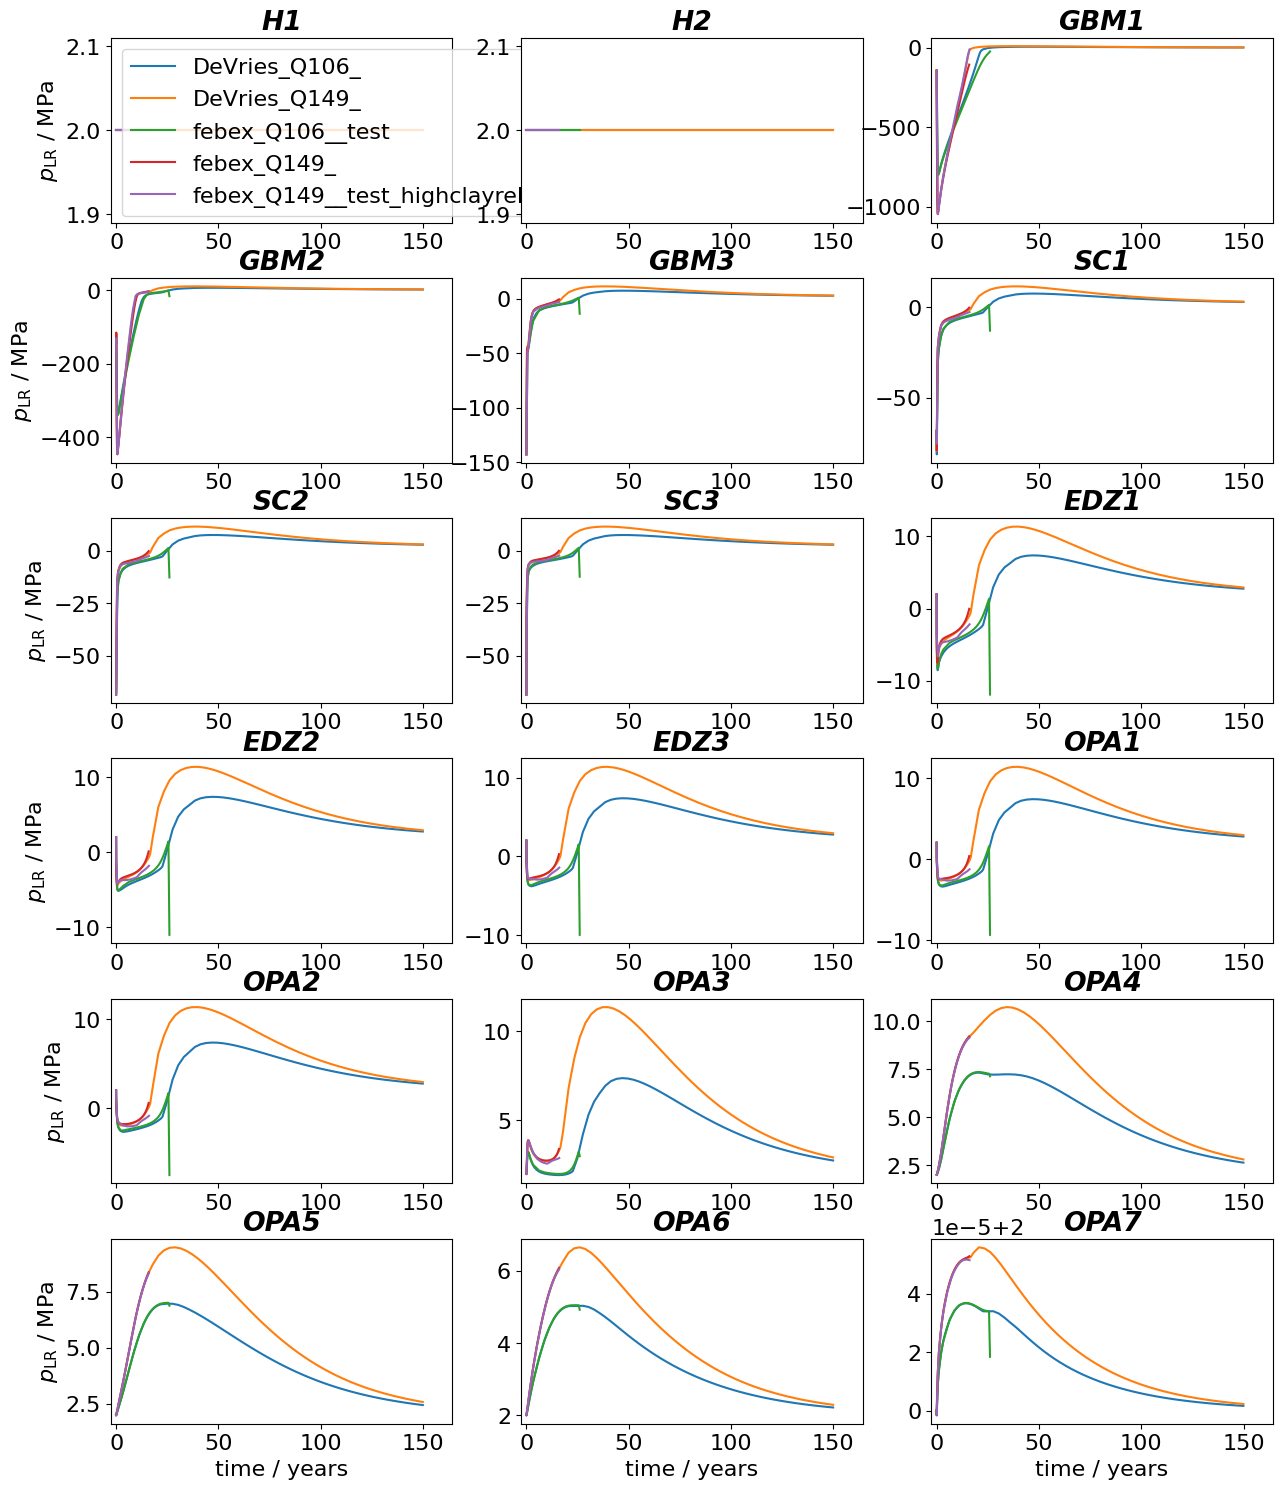

In [58]:
plot_page(-1000,60000, "liquid_pressure")

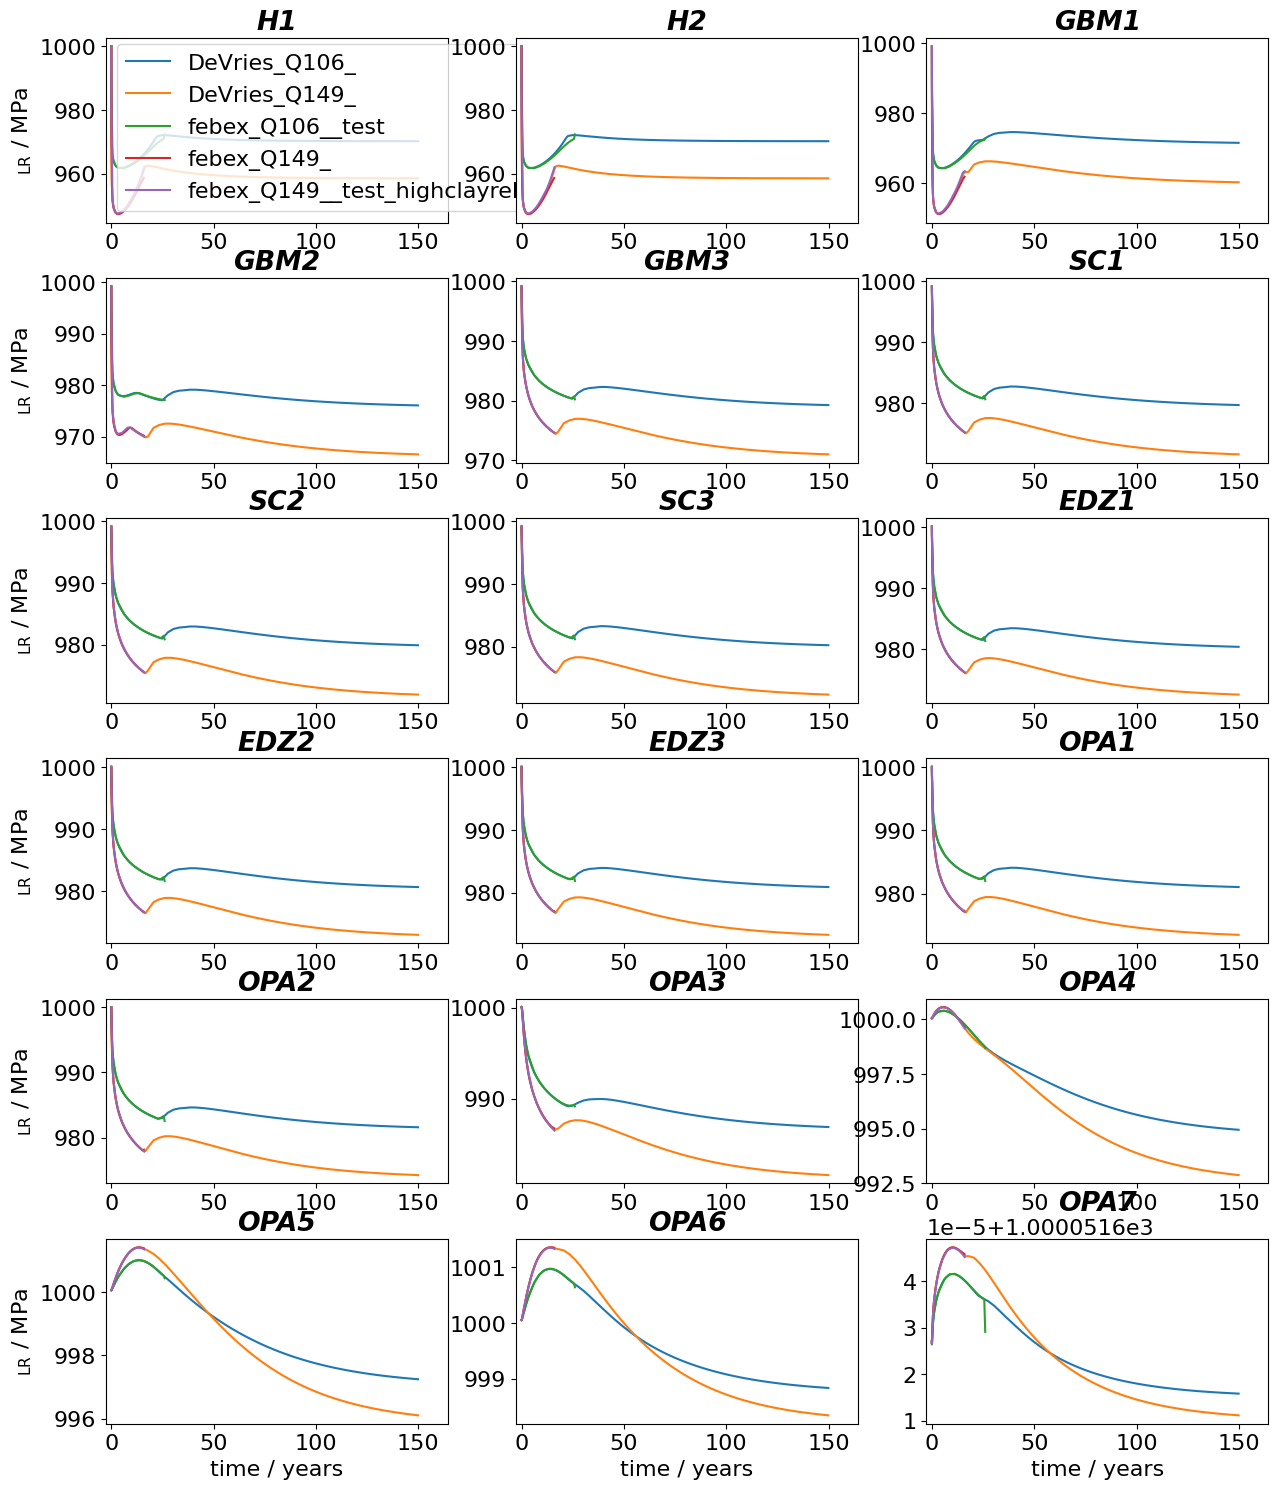

In [63]:
plot_page(-1000,60000, "liquid_density")

In [60]:
#plot_page(-1000,60000, "relative_humidity")

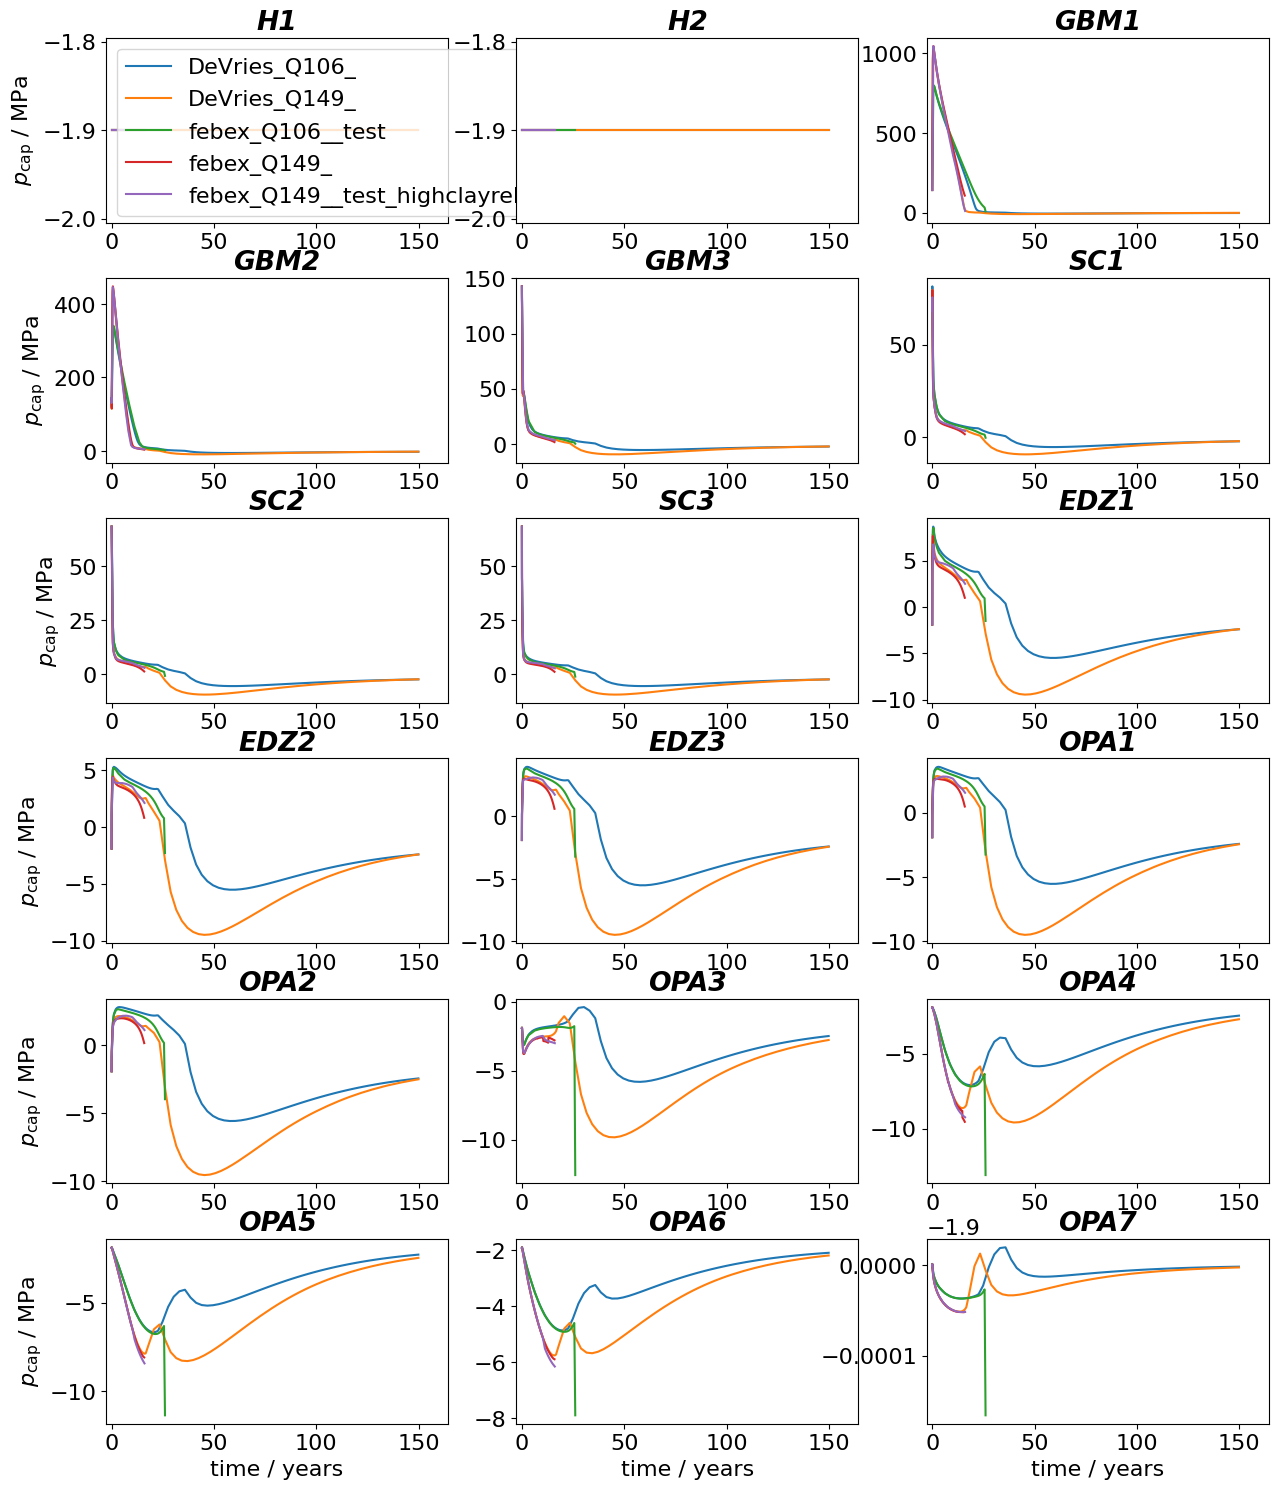

In [64]:
plot_page(-1000,60000, "capillary_pressure")

# 2. Timestepwise analysis

In [54]:
time_steps = [0, 17280000, 34560000, 69120000, 103680000, 473040000, 4730400000]

In [55]:
results_timestepwise = {}

In [56]:
x = [i*0.01 for i in range(1000)]

In [57]:
point_setarray = [(i, 0.01, 0) for i in x]

In [58]:
for heat_power in heat_powers:
    results_timestepwise[heat_power] = {}
    for vd_model in vd_models:
        results_timestepwise[heat_power][vd_model] = {}
        for model in models:
            results_timestepwise[heat_power][vd_model][model] = {}
            for time_step in time_steps:
                results_timestepwise[heat_power][vd_model][model][time_step] = {0: {},17280000: {}, 34560000: {}, 69120000: {}, 103680000: {}, 473040000: {}, 4730400000: {}}
                if heat_power == heat_power0:
                    if "TH2M" in model:
                        for var in result_variables_th2m:
                            results_timestepwise[heat_power][vd_model][model][time_step][var] = pvdfile0[vd_model][model].read_set_data(time_step, var, pointsetarray = point_setarray)
                    else:
                            for var in result_variables_trm:
                                results_timestepwise[heat_power][vd_model][model][time_step][var] = pvdfile0[vd_model][model].read_set_data(time_step, var, pointsetarray = point_setarray)
                else:
                    if "TH2M" in model:
                        for var in result_variables_th2m:
                            results_timestepwise[heat_power][vd_model][model][time_step][var] = pvdfile1[vd_model][model].read_set_data(time_step, var, pointsetarray = point_setarray)
                    else:
                        for var in result_variables_trm:
                            results_timestepwise[heat_power][vd_model][model][time_step][var] = pvdfile1[vd_model][model].read_set_data(time_step, var, pointsetarray = point_setarray)
#vd_models = ["febex", "DeVries"]
#models = ["TH2M","TH2M_const_pGR", "TRM"]

In [59]:
#import plot_settings

In [60]:
def pressure(model):
    if "TH2M" in model:
        return "capillary_pressure"
    else:
        return "pressure"

In [61]:
def prefac(model):
    if "TH2M" in model:
        return 1e-6
    else:
        return -1e-6

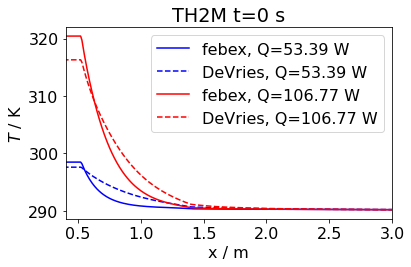

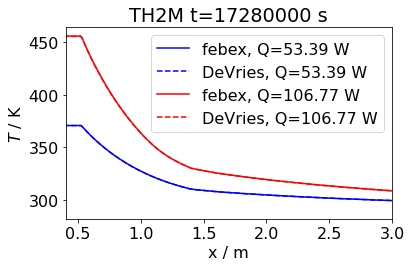

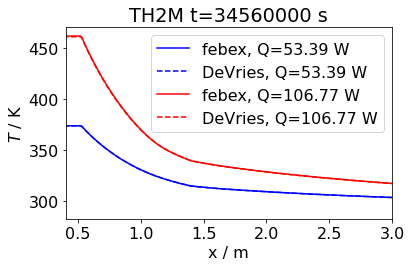

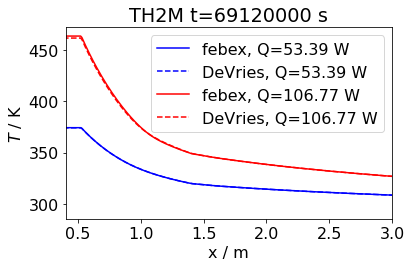

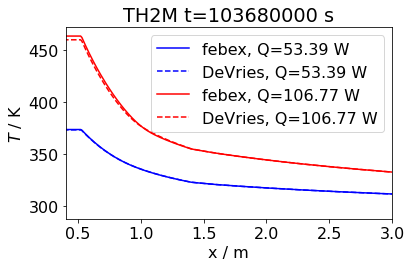

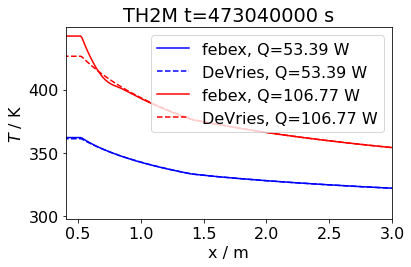

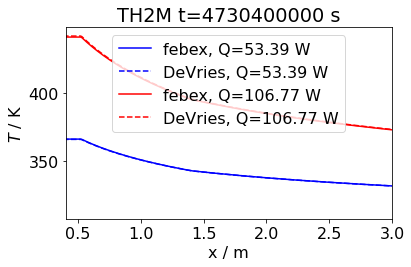

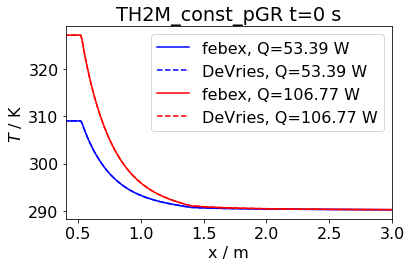

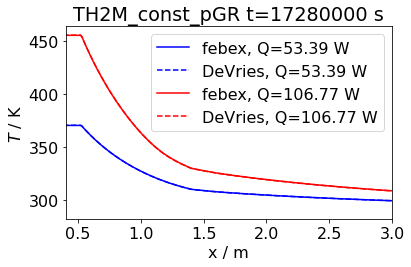

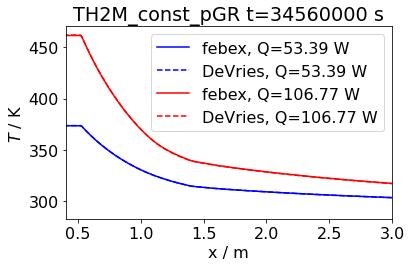

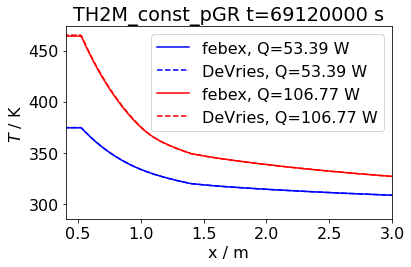

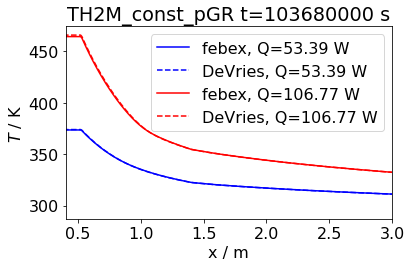

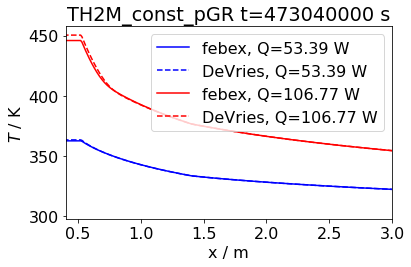

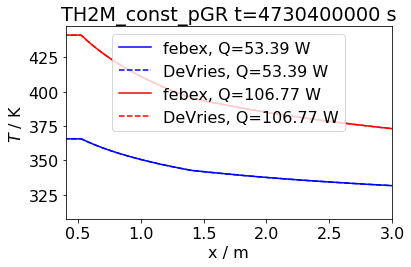

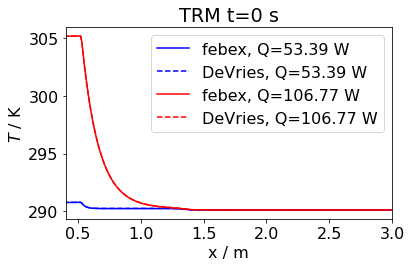

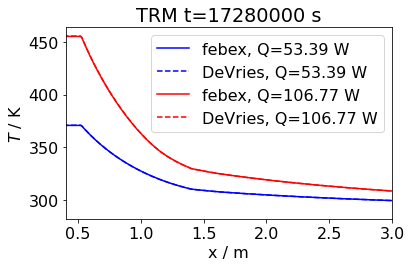

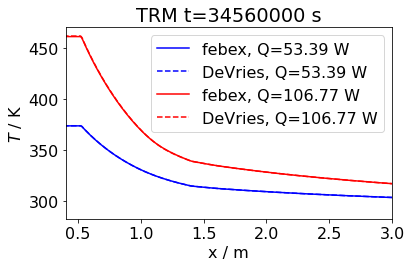

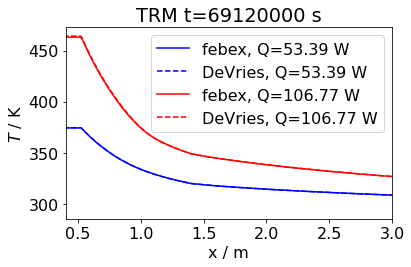

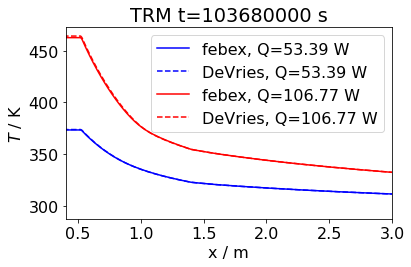

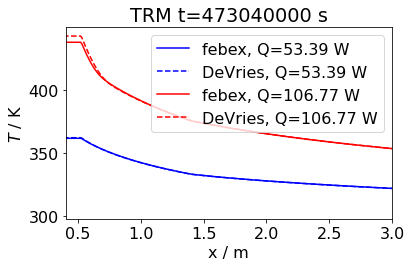

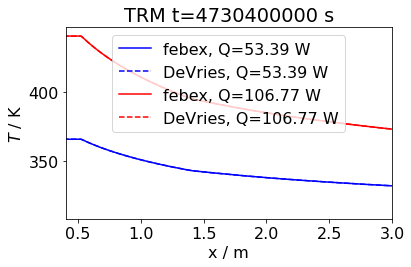

In [62]:
# DeVries vs Febex
def symbols(heat_power, vd_model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if vd_model == "febex":
        symb += "-"
    else:
        symb += "--"
    return symb
for model in models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            plt.plot(x, results_timestepwise[heat_power]["febex"][model][time_step]["temperature"], symbols(heat_power,"febex"), label=f"febex, Q={heat_power:.2f} W")
            plt.plot(x, results_timestepwise[heat_power]["DeVries"][model][time_step]["temperature"], symbols(heat_power,"DeVries"), label=f"DeVries, Q={heat_power:.2f} W")
        plt.legend()
        plt.xlabel("x / m")
        plt.ylabel("$T$ / K")
        plt.xlim([0.4,3])
        plt.title(f"{model} t={time_step} s")
        plt.tight_layout()
        plt.savefig(f"{figdir}febex-vs-deVries_{model}_{time_step}_temperature.pdf")
        plt.show()

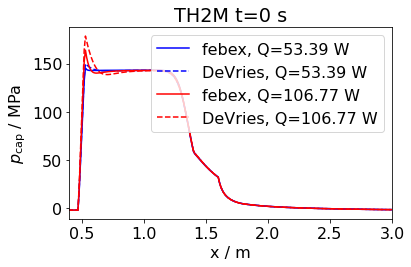

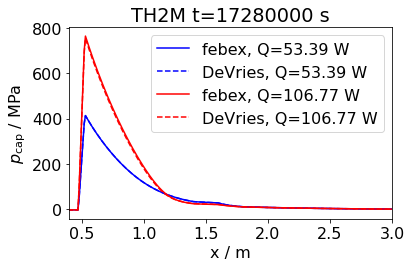

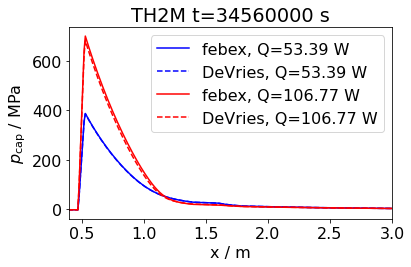

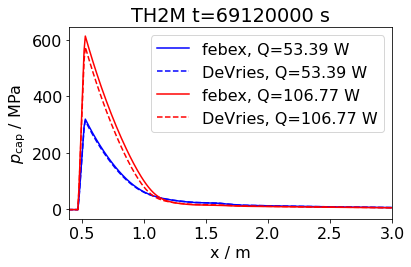

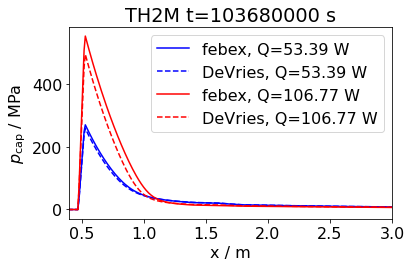

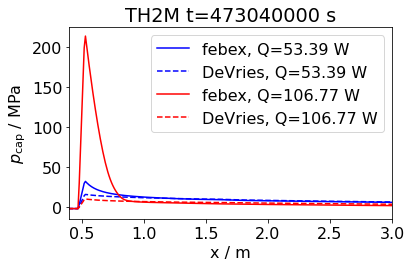

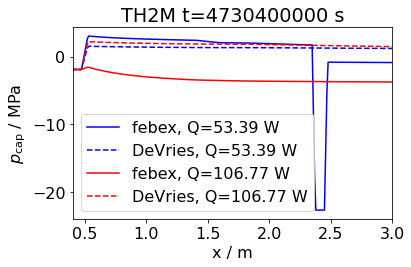

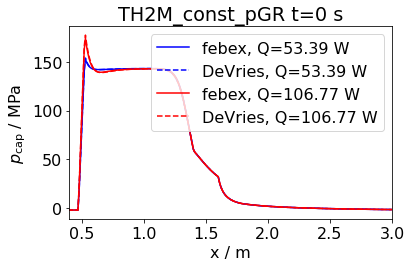

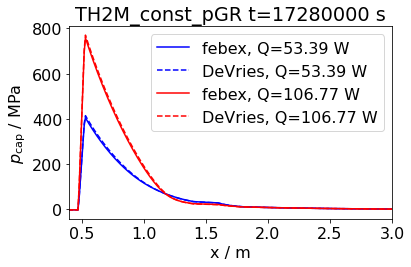

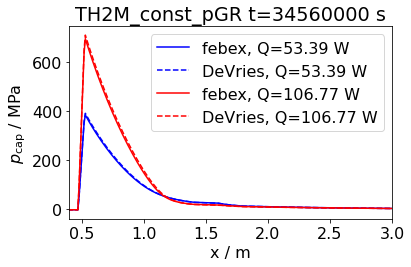

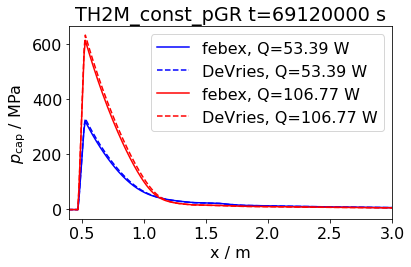

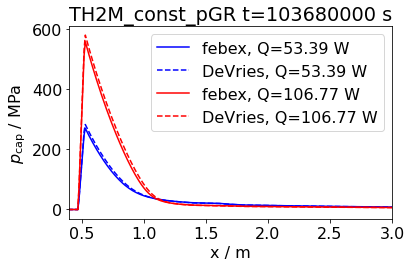

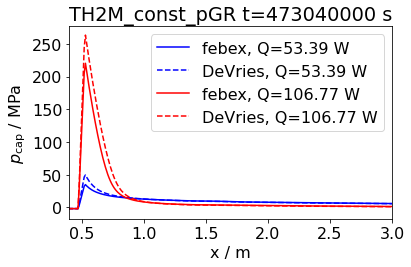

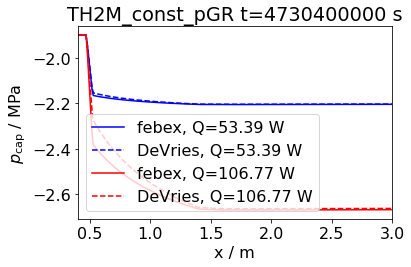

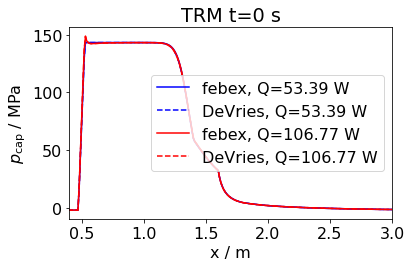

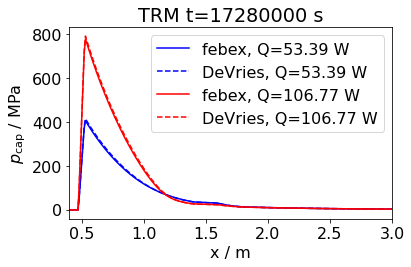

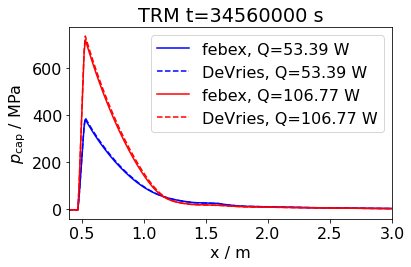

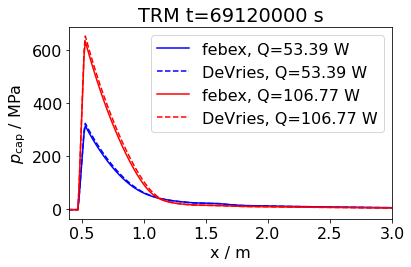

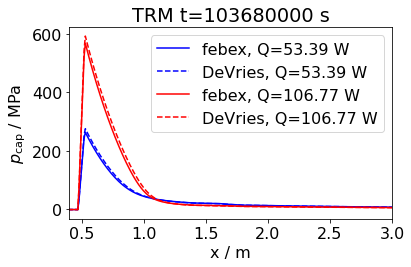

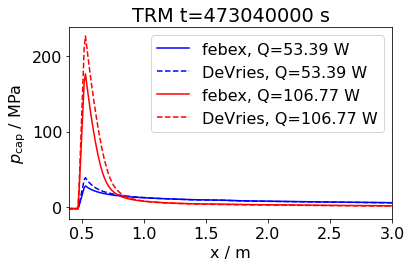

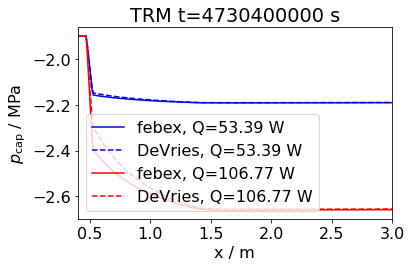

In [63]:
# DeVries vs Febex
def symbols(heat_power, vd_model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if vd_model == "febex":
        symb += "-"
    else:
        symb += "--"
    return symb
for model in models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            plt.plot(x, prefac(model)*results_timestepwise[heat_power]["febex"][model][time_step][pressure(model)], symbols(heat_power,"febex"), label=f"febex, Q={heat_power:.2f} W")
            plt.plot(x, prefac(model)*results_timestepwise[heat_power]["DeVries"][model][time_step][pressure(model)], symbols(heat_power,"DeVries"), label=f"DeVries, Q={heat_power:.2f} W")
        plt.legend()
        plt.xlabel("x / m")
        plt.ylabel("$p_\mathrm{cap}$ / MPa")
        plt.xlim([0.4,3])
        plt.title(f"{model} t={time_step} s")
        plt.tight_layout()
        plt.savefig(f"{figdir}febex-vs-deVries_{model}_{time_step}_capillary_pressure.pdf")
        plt.show()

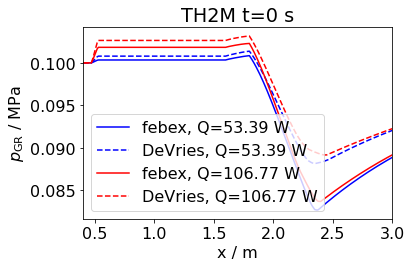

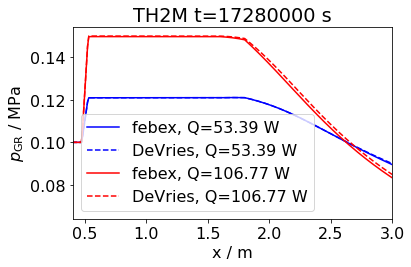

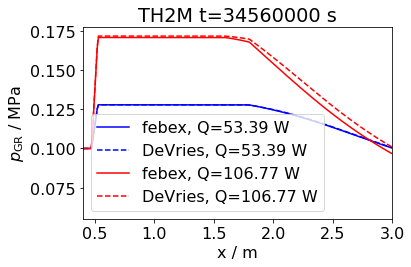

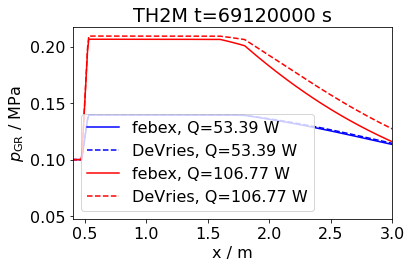

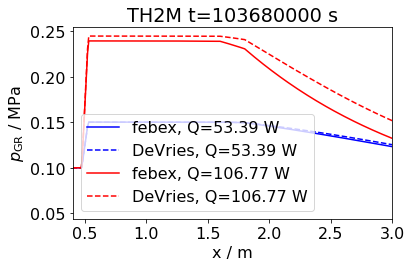

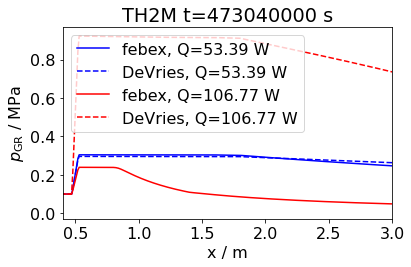

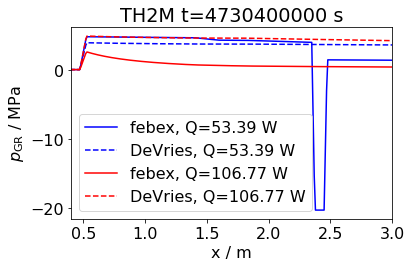

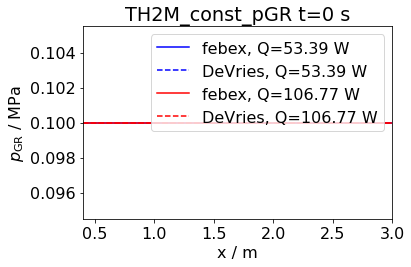

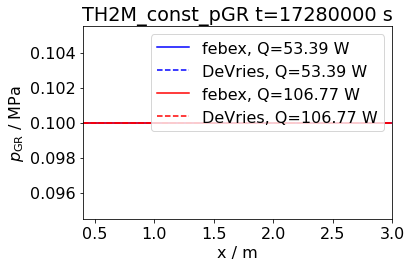

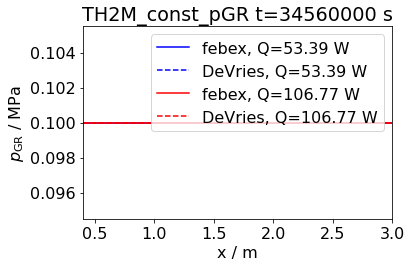

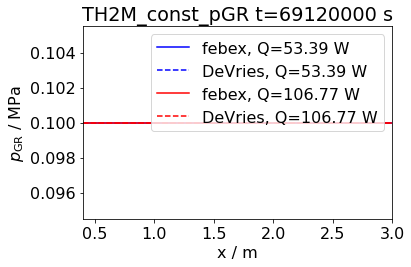

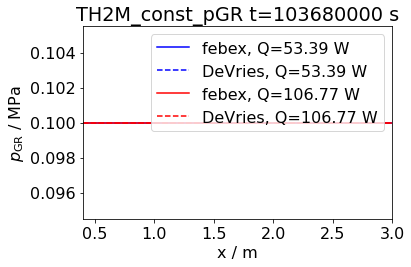

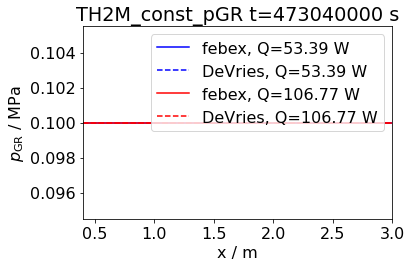

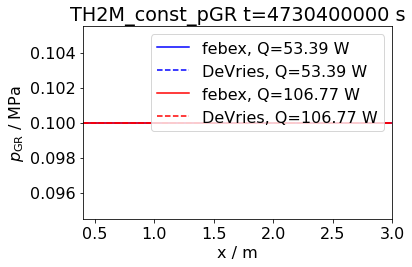

In [64]:
# DeVries vs Febex
def symbols(heat_power, vd_model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if vd_model == "febex":
        symb += "-"
    else:
        symb += "--"
    return symb
for model in models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            if not "TRM" in model:
                plt.plot(x, 1e-6*results_timestepwise[heat_power]["febex"][model][time_step]["gas_pressure"], symbols(heat_power,"febex"), label=f"febex, Q={heat_power:.2f} W")
                plt.plot(x, 1e-6*results_timestepwise[heat_power]["DeVries"][model][time_step]["gas_pressure"], symbols(heat_power,"DeVries"), label=f"DeVries, Q={heat_power:.2f} W")
        if not "TRM" in model:
            plt.legend()
            plt.xlabel("x / m")
            plt.ylabel("$p_\mathrm{GR}$ / MPa")
            plt.xlim([0.4,3])
            plt.title(f"{model} t={time_step} s")
            plt.tight_layout()
            plt.savefig(f"{figdir}febex-vs-deVries_{model}_{time_step}_gas_pressure.pdf")
            plt.show()

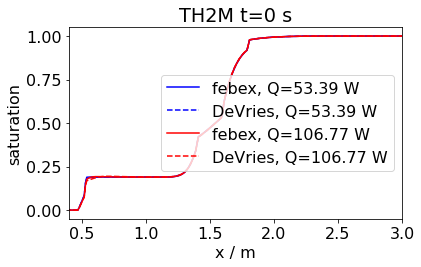

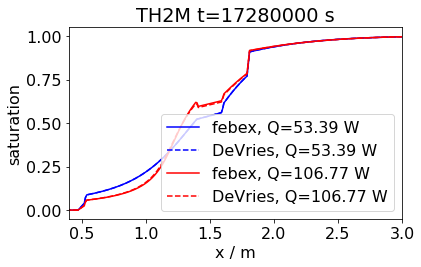

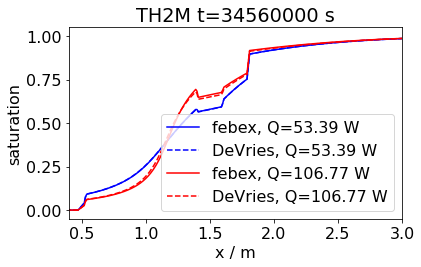

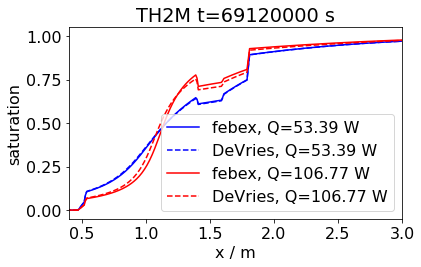

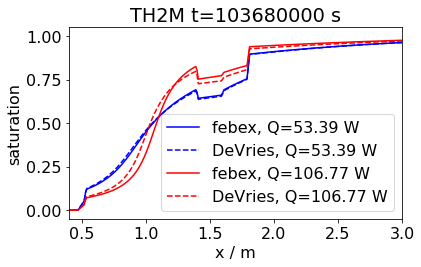

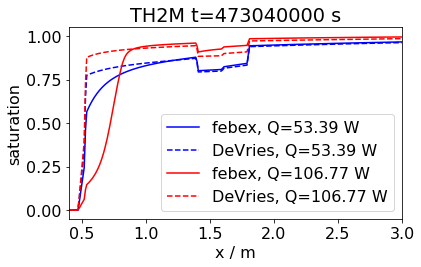

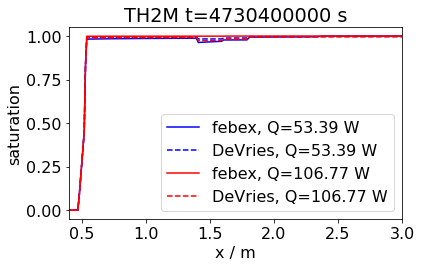

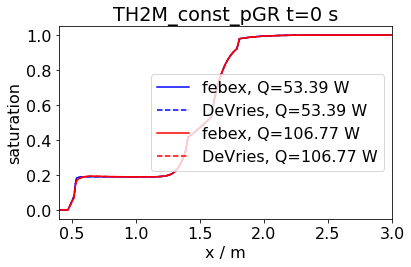

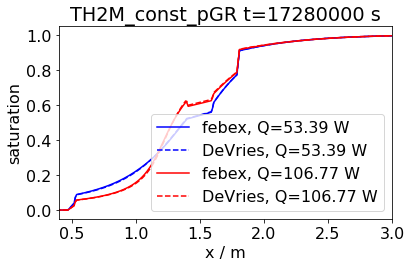

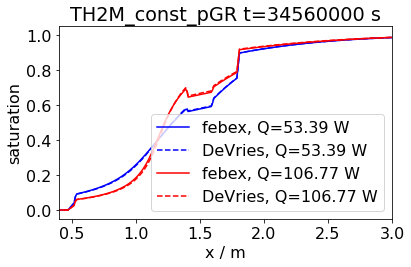

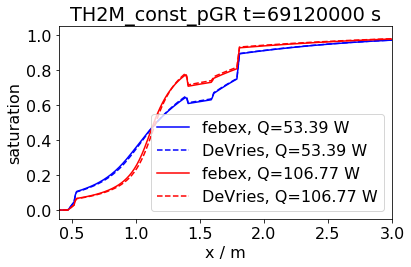

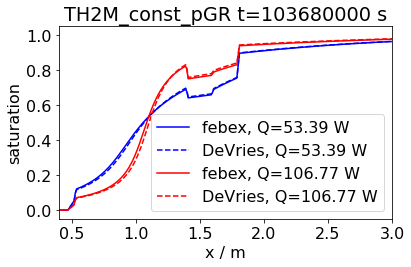

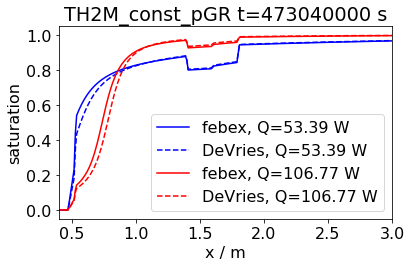

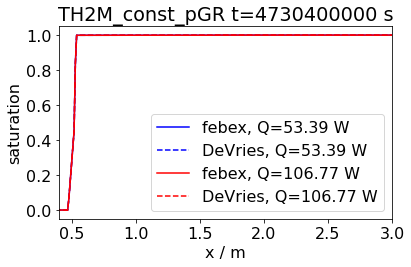

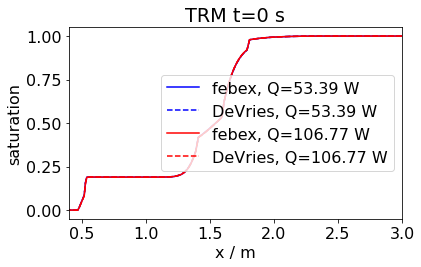

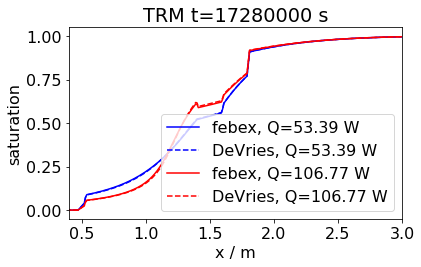

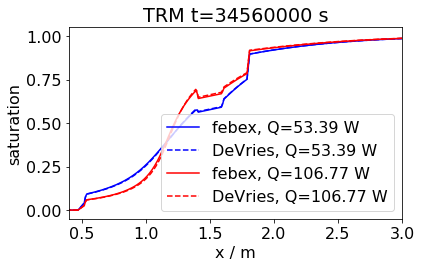

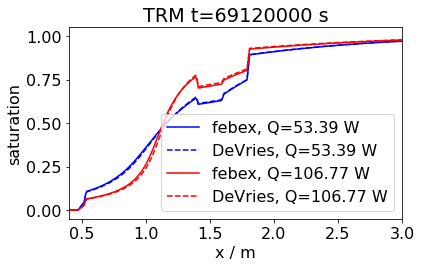

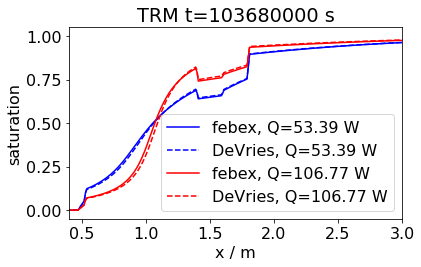

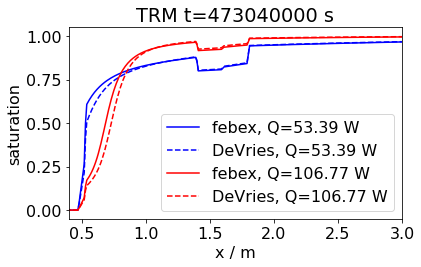

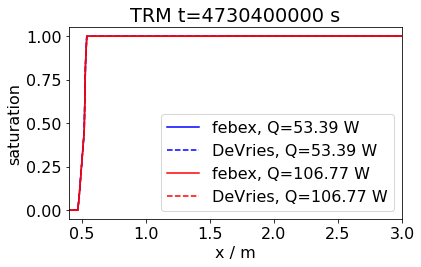

In [65]:
# DeVries vs Febex
def symbols(heat_power, vd_model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if vd_model == "febex":
        symb += "-"
    else:
        symb += "--"
    return symb
for model in models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            plt.plot(x, results_timestepwise[heat_power]["febex"][model][time_step]["saturation"], symbols(heat_power,"febex"), label=f"febex, Q={heat_power:.2f} W")
            plt.plot(x, results_timestepwise[heat_power]["DeVries"][model][time_step]["saturation"], symbols(heat_power,"DeVries"), label=f"DeVries, Q={heat_power:.2f} W")
        plt.legend()
        plt.xlabel("x / m")
        plt.ylabel("saturation")
        plt.xlim([0.4,3])
        plt.title(f"{model} t={time_step} s")
        plt.tight_layout()
        plt.savefig(f"{figdir}febex-vs-deVries_{model}_{time_step}_saturation.pdf")
        plt.show()

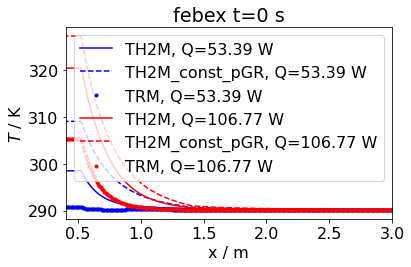

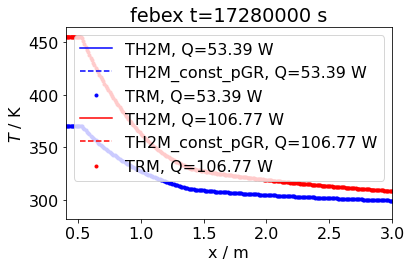

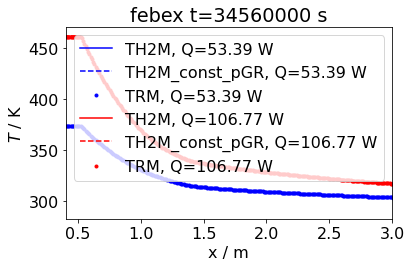

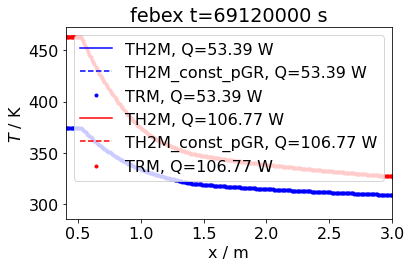

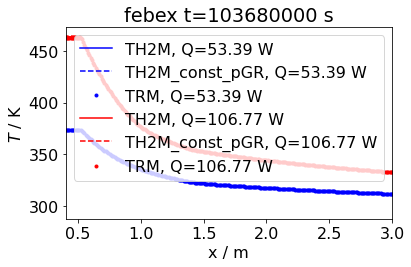

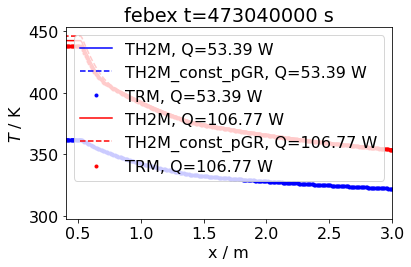

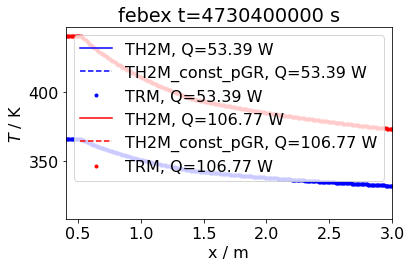

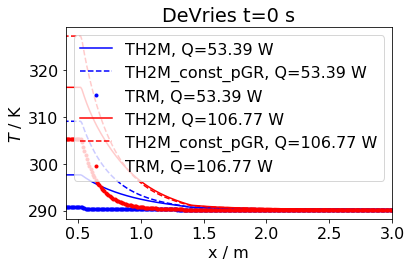

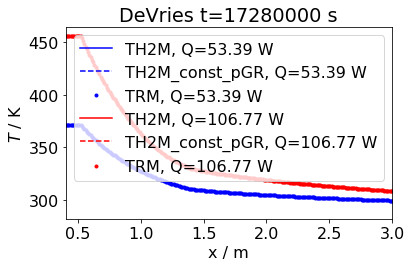

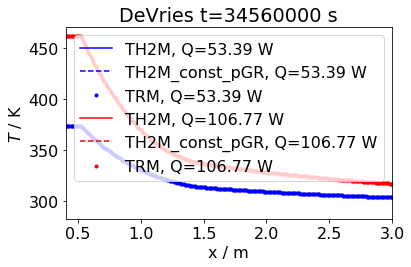

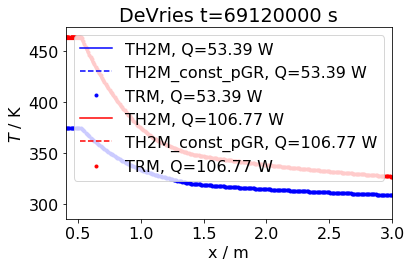

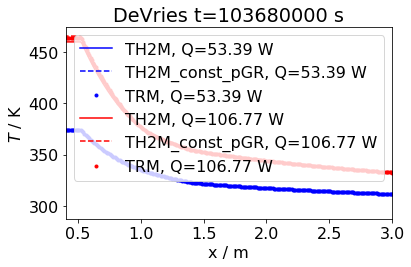

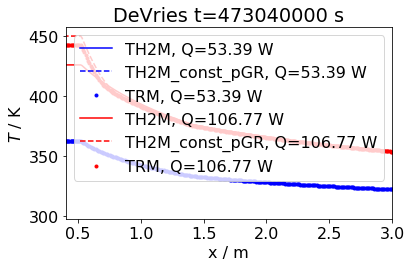

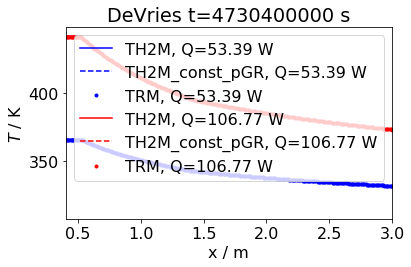

In [66]:
# TH2M vs TH2M_const_pG vs TRM
def symbols(heat_power, model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if model == "TH2M":
        symb += "-"
    elif model == "TH2M_const_pGR":
        symb += "--"
    elif model == "TRM":
        symb += "."
    return symb
for vd_model in vd_models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            for model in models:
                plt.plot(x, results_timestepwise[heat_power][vd_model][model][time_step]["temperature"], symbols(heat_power,model), label=f"{model}, Q={heat_power:.2f} W")
        plt.legend()
        plt.xlabel("x / m")
        plt.ylabel("$T$ / K")
        plt.xlim([0.4,3])
        plt.title(f"{vd_model} t={time_step} s")
        plt.tight_layout()
        plt.savefig(f"{figdir}TH2M-vs-TRM_{vd_model}_{time_step}_temperature.pdf")
        plt.show()

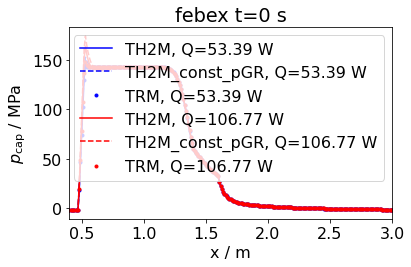

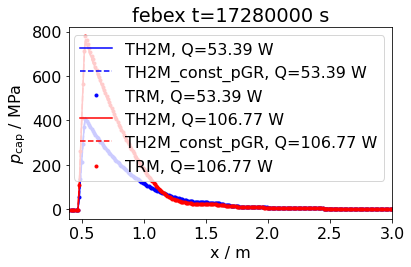

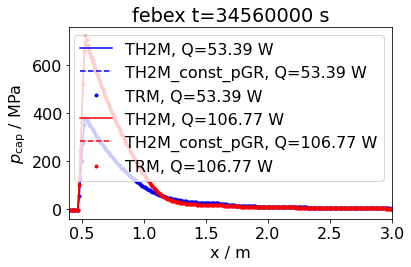

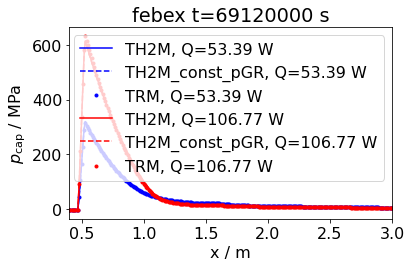

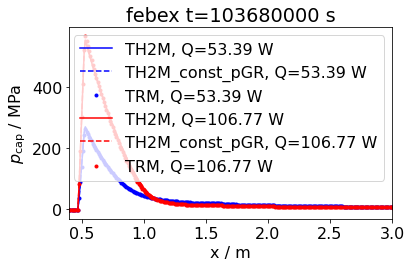

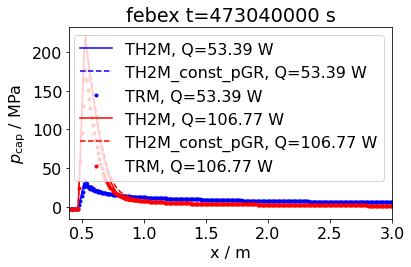

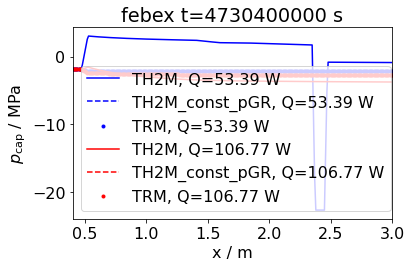

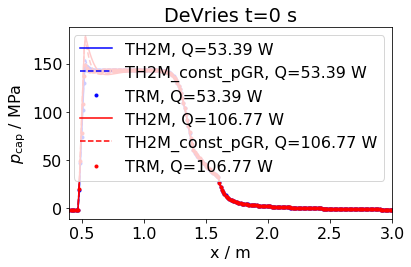

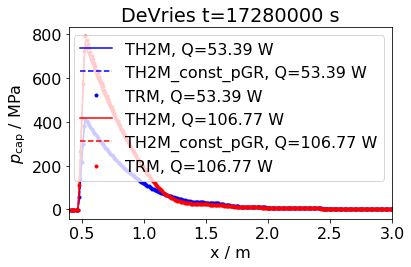

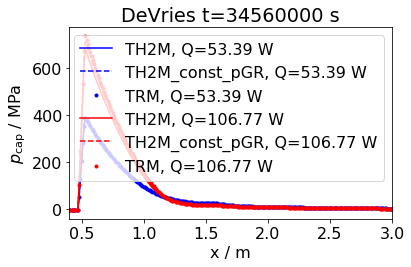

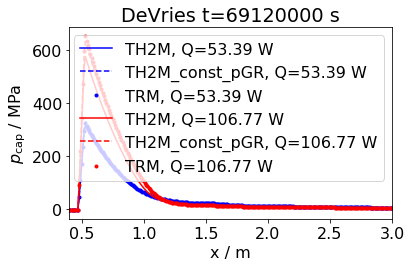

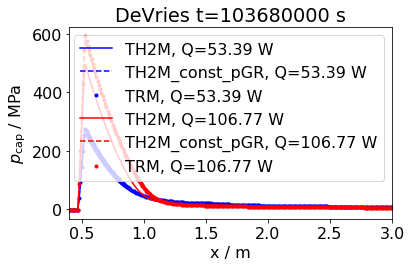

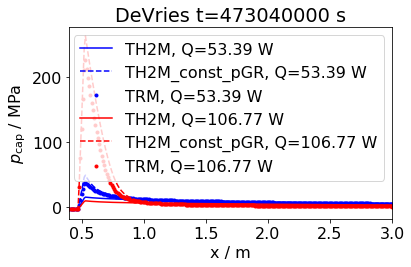

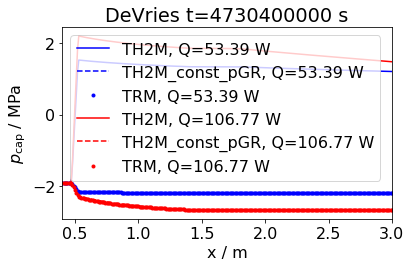

In [67]:
# TH2M vs TH2M_const_pG vs TRM
def symbols(heat_power, model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if model == "TH2M":
        symb += "-"
    elif model == "TH2M_const_pGR":
        symb += "--"
    elif model == "TRM":
        symb += "."
    return symb
for vd_model in vd_models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            for model in models:
                plt.plot(x, prefac(model)*results_timestepwise[heat_power][vd_model][model][time_step][pressure(model)], symbols(heat_power,model), label=f"{model}, Q={heat_power:.2f} W")
        plt.legend()
        plt.xlabel("x / m")
        plt.ylabel("$p_\mathrm{cap}$ / MPa")
        plt.xlim([0.4,3])
        plt.title(f"{vd_model} t={time_step} s")
        plt.tight_layout()
        plt.savefig(f"{figdir}TH2M-vs-TRM_{vd_model}_{time_step}_capillary_pressure.pdf")
        plt.show()

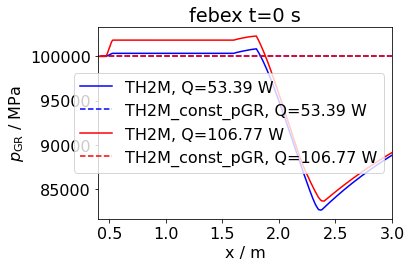

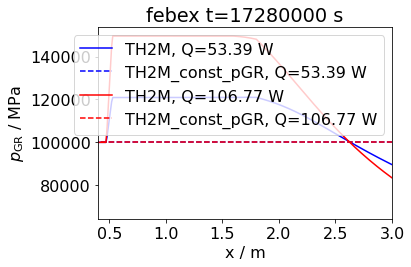

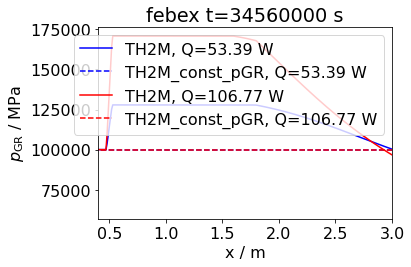

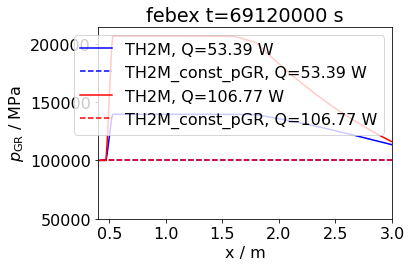

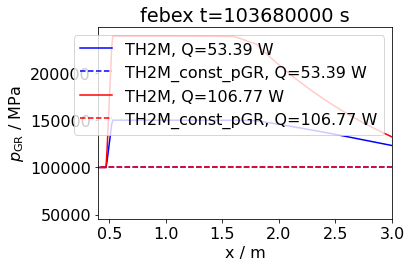

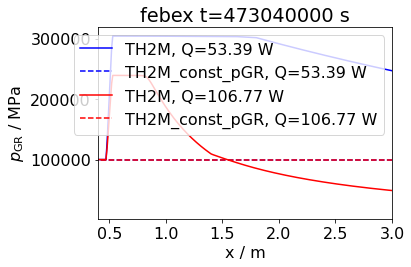

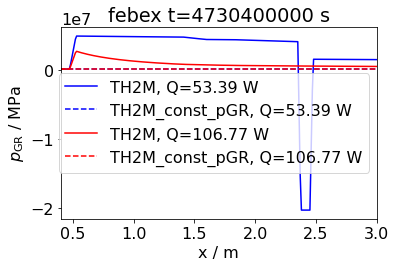

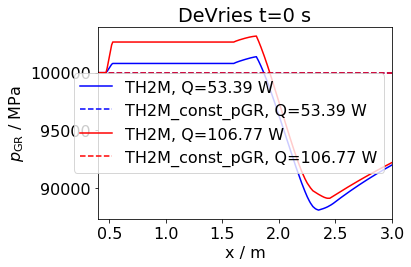

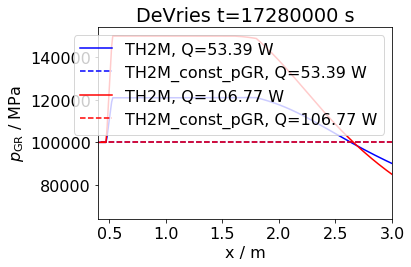

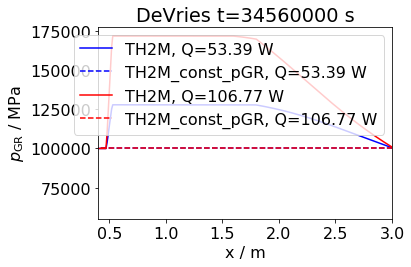

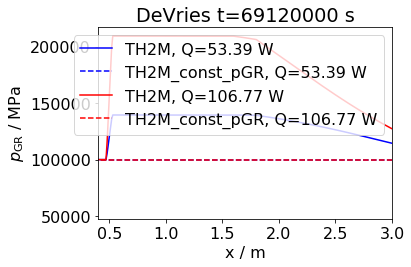

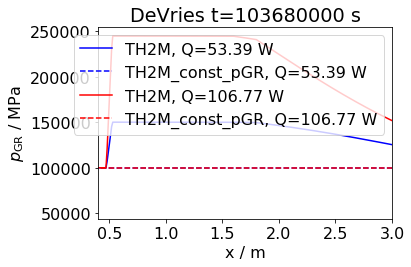

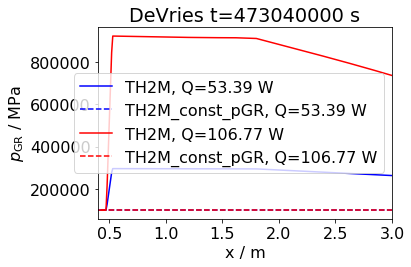

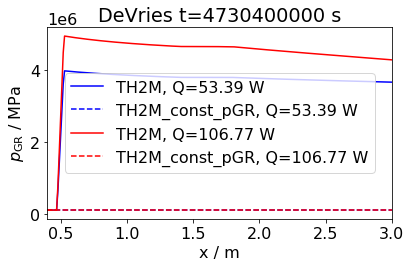

In [68]:
# TH2M vs TH2M_const_pG vs TRM
def symbols(heat_power, model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if model == "TH2M":
        symb += "-"
    elif model == "TH2M_const_pGR":
        symb += "--"
    elif model == "TRM":
        symb += "."
    return symb
for vd_model in vd_models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            for model in models:
                if not "TRM" in model:
                    plt.plot(x, results_timestepwise[heat_power][vd_model][model][time_step]["gas_pressure"], symbols(heat_power,model), label=f"{model}, Q={heat_power:.2f} W")
        plt.legend()
        plt.xlabel("x / m")
        plt.ylabel("$p_\mathrm{GR}$ / MPa")
        plt.xlim([0.4,3])
        plt.title(f"{vd_model} t={time_step} s")
        plt.tight_layout()
        plt.savefig(f"{figdir}TH2M-vs-TRM_{vd_model}_{time_step}_gas_pressure.pdf")
        plt.show()

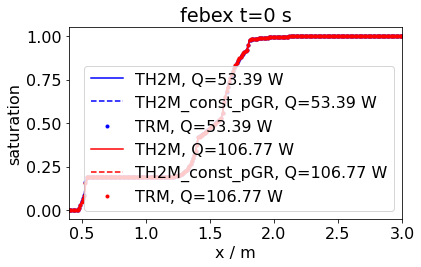

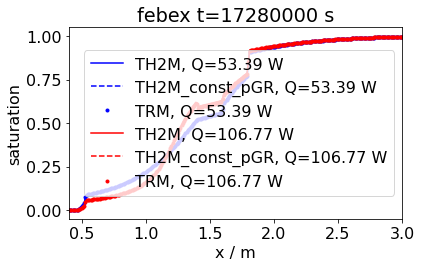

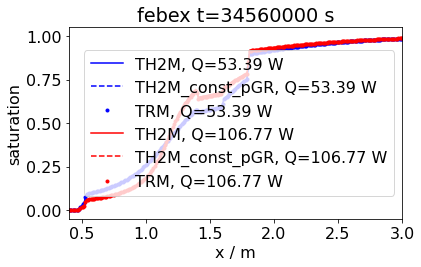

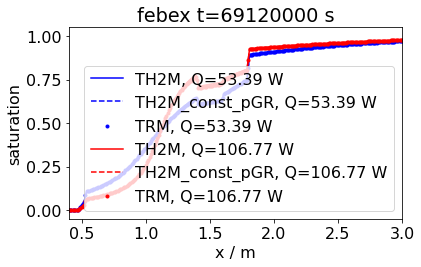

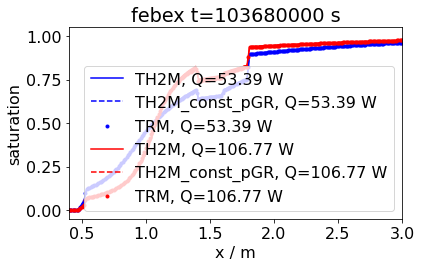

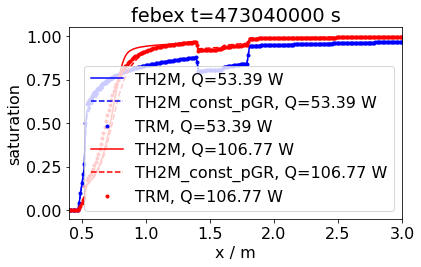

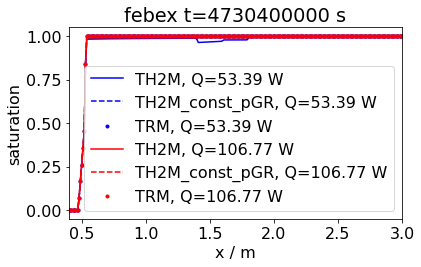

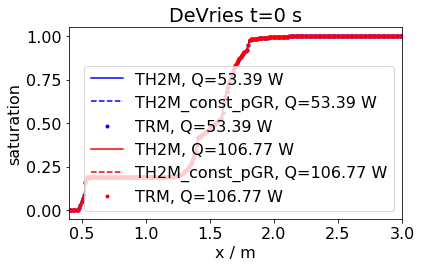

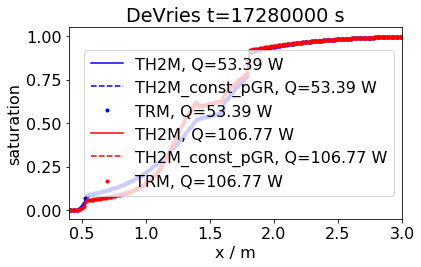

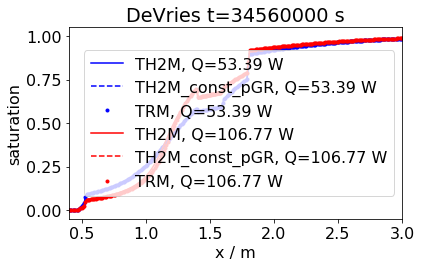

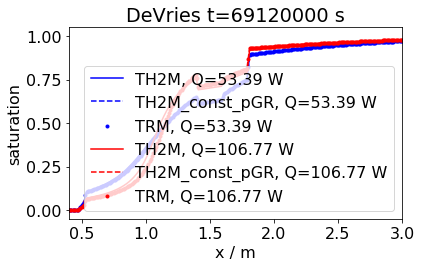

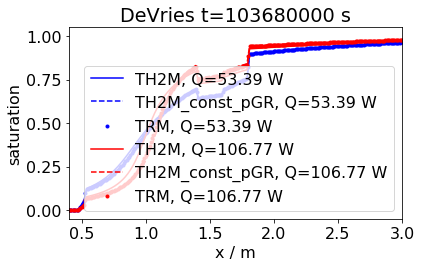

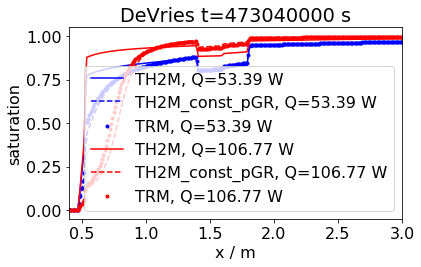

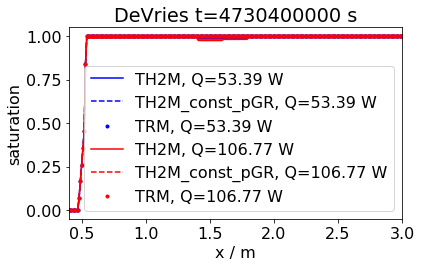

In [69]:
# TH2M vs TH2M_const_pG vs TRM
def symbols(heat_power, model):
    symb = ""
    if heat_power < 70:
        symb += "b"
    else:
        symb += "r"
    if model == "TH2M":
        symb += "-"
    elif model == "TH2M_const_pGR":
        symb += "--"
    elif model == "TRM":
        symb += "."
    return symb
for vd_model in vd_models:
    for time_step in time_steps:
        for heat_power in heat_powers:
            for model in models:
                plt.plot(x, results_timestepwise[heat_power][vd_model][model][time_step]["saturation"], symbols(heat_power,model), label=f"{model}, Q={heat_power:.2f} W")
        plt.legend()
        plt.xlabel("x / m")
        plt.ylabel("saturation")
        plt.xlim([0.4,3])
        plt.title(f"{vd_model} t={time_step} s")
        plt.tight_layout()
        plt.savefig(f"{figdir}TH2M-vs-TRM_{vd_model}_{time_step}_saturation.pdf")
        plt.show()

In [70]:
# Q_low vs Q_high